In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

LOCATION = "Main"
START_DATE = "2024-01-01"
END_DATE   = "2025-12-31"   # 24 months

# scale (reasonable defaults for a demo)
N_ITEMS = 6000
N_PATRONS = 3000
N_TXN = 20000


In [3]:
dates = pd.date_range(START_DATE, END_DATE, freq="D")

def semester_weight(d):
    m = d.month
    if m in [8,9,10,11,12]:
        return 1.25  # fall semester busier
    if m in [1,2,3,4,5]:
        return 1.15  # spring semester
    if m in [6,7]:
        return 0.75  # summer slower
    return 1.0

weights = np.array([semester_weight(d) for d in dates], dtype=float)
weights = weights / weights.sum()


In [4]:
collections = ["Book", "DVD", "Laptop", "CourseReserve"]
collection_p = [0.78, 0.10, 0.04, 0.08]

subjects = ["HSS", "STEM", "Law", "Business", "Medicine", "Arts"]
subject_p = [0.33, 0.28, 0.10, 0.12, 0.08, 0.09]

items = pd.DataFrame({
    "item_id": [f"I{str(i).zfill(6)}" for i in range(1, N_ITEMS+1)],
    "collection": np.random.choice(collections, size=N_ITEMS, p=collection_p),
    "subject": np.random.choice(subjects, size=N_ITEMS, p=subject_p),
})

policy_map = {"Book": 28, "DVD": 7, "Laptop": 3, "CourseReserve": 1}
items["loan_policy_days"] = items["collection"].map(policy_map)
items["home_location"] = LOCATION

items.head()


,item_id,collection,subject,loan_policy_days,home_location
0,I000001,Book,Law,28,Main
1,I000002,CourseReserve,HSS,1,Main
2,I000003,Book,Medicine,28,Main
3,I000004,Book,Law,28,Main
4,I000005,Book,HSS,28,Main


In [5]:
patron_groups = ["Undergrad", "Grad", "Faculty", "Staff", "Community"]
patron_p = [0.52, 0.22, 0.10, 0.10, 0.06]

risk_profiles = ["low", "medium", "high"]
risk_p = [0.55, 0.35, 0.10]  # late-return tendency

patrons = pd.DataFrame({
    "patron_id": [f"P{str(i).zfill(6)}" for i in range(1, N_PATRONS+1)],
    "patron_group": np.random.choice(patron_groups, size=N_PATRONS, p=patron_p),
    "risk_profile": np.random.choice(risk_profiles, size=N_PATRONS, p=risk_p),
})

patrons.head()


,patron_id,patron_group,risk_profile
0,P000001,Grad,low
1,P000002,Undergrad,medium
2,P000003,Undergrad,medium
3,P000004,Faculty,low
4,P000005,Grad,low


In [7]:
checkout_dates = np.random.choice(dates, size=N_TXN, replace=True, p=weights)

txns = pd.DataFrame({
    "txn_id": [f"T{str(i).zfill(7)}" for i in range(1, N_TXN+1)],
    "checkout_dt": pd.to_datetime(checkout_dates),
    "item_id": np.random.choice(items["item_id"], size=N_TXN, replace=True),
    "patron_id": np.random.choice(patrons["patron_id"], size=N_TXN, replace=True),
})
txns["checkout_location"] = LOCATION

# join loan policy + collection
txns = txns.merge(items[["item_id","loan_policy_days","collection","subject"]], on="item_id", how="left")
txns["due_dt"] = txns["checkout_dt"] + pd.to_timedelta(txns["loan_policy_days"], unit="D")

# attach patron attributes
p_group = patrons.set_index("patron_id")["patron_group"]
p_risk = patrons.set_index("patron_id")["risk_profile"]
txns["patron_group"] = txns["patron_id"].map(p_group)
txns["risk_profile"] = txns["patron_id"].map(p_risk)

# renewal: faculty/grad more likely; course reserve very low
base_renew = np.where(txns["patron_group"].eq("Faculty"), 0.85,
              np.where(txns["patron_group"].eq("Grad"), 0.55,
              np.where(txns["patron_group"].eq("Undergrad"), 0.35, 0.25)))
base_renew = np.where(txns["collection"].eq("CourseReserve"), 0.05, base_renew)

txns["renewal_count"] = np.random.binomial(n=2, p=np.clip(base_renew, 0, 1))

# return behavior
not_returned_p = 0.02  # 2% still checked out
not_returned = np.random.rand(N_TXN) < not_returned_p

late_mean = txns["risk_profile"].map({"low": 0.8, "medium": 2.0, "high": 5.0}).astype(float)
late_days = np.maximum(0, np.random.poisson(lam=late_mean))

early_days = np.maximum(0, np.random.poisson(lam=1.2))
returned_dt = txns["due_dt"] - pd.to_timedelta(early_days, unit="D") + pd.to_timedelta(late_days, unit="D")

txns["return_dt"] = pd.to_datetime(returned_dt)
txns.loc[not_returned, "return_dt"] = pd.NaT

txns.head()


,txn_id,checkout_dt,item_id,patron_id,checkout_location,loan_policy_days,collection,subject,due_dt,patron_group,risk_profile,renewal_count,return_dt
0,T0000001,2025-07-08,I002093,P001137,Main,28,Book,STEM,2025-08-05,Staff,low,0,2025-08-03
1,T0000002,2025-01-22,I000668,P000309,Main,28,Book,Business,2025-02-19,Undergrad,medium,1,2025-02-18
2,T0000003,2024-10-02,I004834,P002140,Main,28,Book,HSS,2024-10-30,Grad,medium,2,2024-10-30
3,T0000004,2025-07-22,I000037,P000460,Main,28,Book,Business,2025-08-19,Undergrad,low,1,2025-08-17
4,T0000005,2025-03-11,I005825,P000665,Main,28,Book,Business,2025-04-08,Undergrad,medium,1,2025-04-08


In [8]:
txns["is_returned"] = txns["return_dt"].notna()
txns["is_late"] = txns["is_returned"] & (txns["return_dt"] > txns["due_dt"])
txns["late_days"] = np.where(txns["is_late"], (txns["return_dt"] - txns["due_dt"]).dt.days, 0)

kpi = {
    "transactions": len(txns),
    "unique_patrons": txns["patron_id"].nunique(),
    "late_rate": float(txns["is_late"].mean()),
    "renew_rate": float((txns["renewal_count"] > 0).mean()),
    "not_returned_rate": float((~txns["is_returned"]).mean()),
    "avg_late_days_if_late": float(txns.loc[txns["is_late"], "late_days"].mean()),
    "p95_late_days_if_late": float(txns.loc[txns["is_late"], "late_days"].quantile(0.95)),
}
pd.Series(kpi)


transactions             20000.000000
unique_patrons            2996.000000
late_rate                    0.124900
renew_rate                   0.595250
not_returned_rate            0.020900
avg_late_days_if_late        2.339071
p95_late_days_if_late        5.000000
dtype: float64

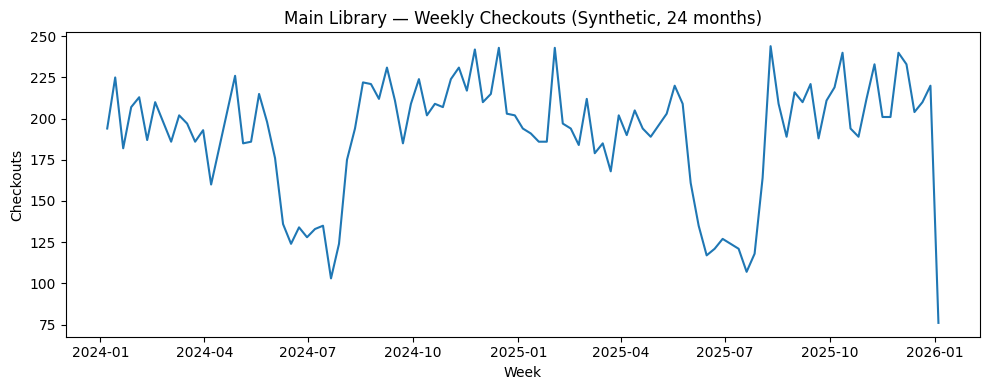

In [9]:
weekly = (
    txns.groupby(pd.Grouper(key="checkout_dt", freq="W"))
        .size()
        .rename("checkouts")
        .reset_index()
)

plt.figure(figsize=(10,4))
plt.plot(weekly["checkout_dt"], weekly["checkouts"])
plt.title("Main Library — Weekly Checkouts (Synthetic, 24 months)")
plt.xlabel("Week")
plt.ylabel("Checkouts")
plt.tight_layout()
plt.show()


In [10]:
def kpi_table(df: pd.DataFrame, group_cols):
    out = (df
        .groupby(group_cols)
        .agg(
            transactions=("txn_id","count"),
            unique_patrons=("patron_id","nunique"),
            late_rate=("is_late","mean"),
            renew_rate=("renewal_count", lambda s: (s > 0).mean()),
            not_returned_rate=("is_returned", lambda s: (~s).mean()),
            avg_late_days_if_late=("late_days", lambda s: s[s>0].mean() if (s>0).any() else 0),
        )
        .reset_index()
    )
    out["late_rate"] = out["late_rate"].round(3)
    out["renew_rate"] = out["renew_rate"].round(3)
    out["not_returned_rate"] = out["not_returned_rate"].round(3)
    out["avg_late_days_if_late"] = out["avg_late_days_if_late"].round(2)
    return out.sort_values("transactions", ascending=False)

kpi_by_group = kpi_table(txns, ["patron_group"])
kpi_by_collection = kpi_table(txns, ["collection"])
kpi_by_group, kpi_by_collection.head()


(  patron_group  transactions  unique_patrons  late_rate  renew_rate  \
 4    Undergrad         10503            1572      0.121       0.540   
 2         Grad          4159             622      0.127       0.732   
 1      Faculty          2065             312      0.124       0.905   
 3        Staff          1936             290      0.114       0.389   
 0    Community          1337             200      0.163       0.426   
 
    not_returned_rate  avg_late_days_if_late  
 4              0.023                   2.31  
 2              0.019                   2.39  
 1              0.018                   2.40  
 3              0.017                   2.34  
 0              0.018                   2.32  ,
       collection  transactions  unique_patrons  late_rate  renew_rate  \
 0           Book         15652            2981      0.125       0.640   
 2            DVD          1974            1426      0.124       0.636   
 1  CourseReserve          1657            1298      0.129   

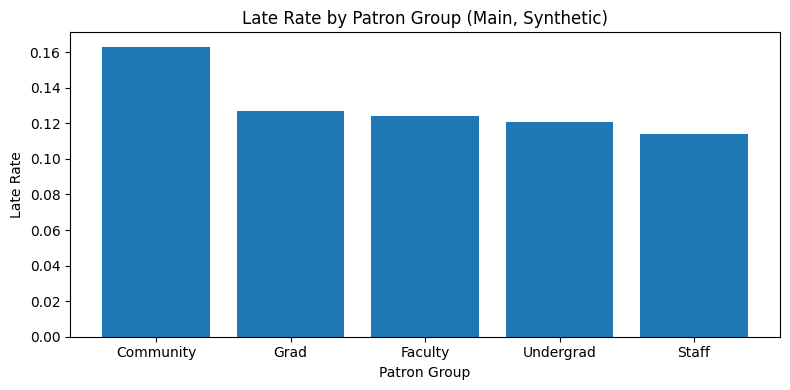

In [11]:
df = kpi_by_group.sort_values("late_rate", ascending=False)

plt.figure(figsize=(8,4))
plt.bar(df["patron_group"], df["late_rate"])
plt.title("Late Rate by Patron Group (Main, Synthetic)")
plt.xlabel("Patron Group")
plt.ylabel("Late Rate")
plt.tight_layout()
plt.show()


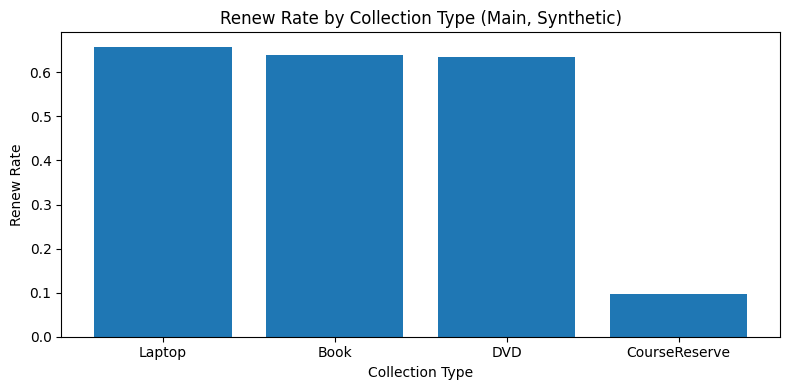

In [12]:
df = kpi_by_collection.sort_values("renew_rate", ascending=False)

plt.figure(figsize=(8,4))
plt.bar(df["collection"], df["renew_rate"])
plt.title("Renew Rate by Collection Type (Main, Synthetic)")
plt.xlabel("Collection Type")
plt.ylabel("Renew Rate")
plt.tight_layout()
plt.show()


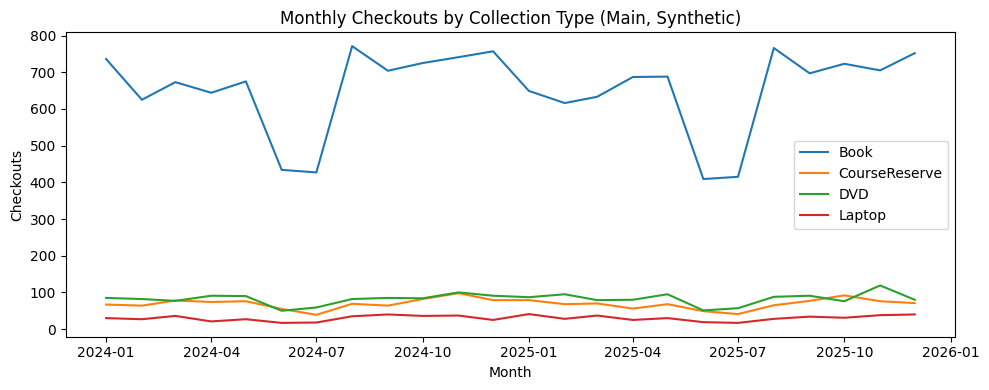

In [13]:
monthly = (txns
    .assign(month=txns["checkout_dt"].dt.to_period("M").dt.to_timestamp())
    .groupby(["month","collection"])
    .size()
    .rename("checkouts")
    .reset_index()
)

pivot = monthly.pivot(index="month", columns="collection", values="checkouts").fillna(0)

plt.figure(figsize=(10,4))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=col)

plt.title("Monthly Checkouts by Collection Type (Main, Synthetic)")
plt.xlabel("Month")
plt.ylabel("Checkouts")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
N_HOLDS = 4500  # reasonable demo size

# Hold requests happen on busier days more often
request_dates = np.random.choice(dates, size=N_HOLDS, replace=True, p=weights)

holds = pd.DataFrame({
    "hold_id": [f"H{str(i).zfill(7)}" for i in range(1, N_HOLDS+1)],
    "request_dt": pd.to_datetime(request_dates),
    "item_id": np.random.choice(items["item_id"], size=N_HOLDS, replace=True),
    "patron_id": np.random.choice(patrons["patron_id"], size=N_HOLDS, replace=True),
})
holds["pickup_location"] = LOCATION

# Make some collections more likely to be held (CourseReserve & Laptop)
item_collection = items.set_index("item_id")["collection"]
holds["collection"] = holds["item_id"].map(item_collection)

boost = holds["collection"].map({"CourseReserve": 2.2, "Laptop": 1.6, "Book": 1.0, "DVD": 1.1}).fillna(1.0)
# Turn boost into probabilities by resampling: keep holds where random < scaled prob
keep = np.random.rand(N_HOLDS) < np.clip(0.6 * (boost / boost.mean()), 0.2, 0.95)
holds = holds.loc[keep].reset_index(drop=True)

holds.head()


,hold_id,request_dt,item_id,patron_id,pickup_location,collection
0,H0000002,2025-08-17,I004421,P002642,Main,Book
1,H0000006,2025-06-21,I002486,P002884,Main,CourseReserve
2,H0000007,2025-01-08,I004575,P001248,Main,Book
3,H0000008,2025-07-13,I000789,P000416,Main,Book
4,H0000011,2025-11-21,I001610,P001510,Main,Book


In [15]:
# statuses
status = np.random.choice(
    ["fulfilled", "cancelled", "expired", "pending"],
    size=len(holds),
    p=[0.74, 0.10, 0.08, 0.08]
)
holds["status"] = status

# waiting time distribution: long-tail, and worse during peak semesters
peak_factor = holds["request_dt"].dt.month.isin([8,9,10,11,12,1,2,3,4,5]).astype(int)
# base wait days: lognormal long tail
base_wait = np.random.lognormal(mean=1.1, sigma=0.55, size=len(holds))  # ~3 days median-ish
wait_days = base_wait + peak_factor * np.random.lognormal(mean=0.7, sigma=0.5, size=len(holds))

wait_days = np.clip(wait_days, 0.2, 30)  # cap at 30 days for sanity
holds["wait_days"] = wait_days.round(1)

holds["fulfill_dt"] = pd.NaT
fulfilled_mask = holds["status"].eq("fulfilled")
holds.loc[fulfilled_mask, "fulfill_dt"] = holds.loc[fulfilled_mask, "request_dt"] + pd.to_timedelta(
    holds.loc[fulfilled_mask, "wait_days"], unit="D"
)

holds.head()


,hold_id,request_dt,item_id,patron_id,pickup_location,collection,status,wait_days,fulfill_dt
0,H0000002,2025-08-17,I004421,P002642,Main,Book,fulfilled,6.6,2025-08-23 14:24:00
1,H0000006,2025-06-21,I002486,P002884,Main,CourseReserve,expired,5.7,NaT
2,H0000007,2025-01-08,I004575,P001248,Main,Book,fulfilled,3.6,2025-01-11 14:24:00
3,H0000008,2025-07-13,I000789,P000416,Main,Book,fulfilled,2.1,2025-07-15 02:24:00
4,H0000011,2025-11-21,I001610,P001510,Main,Book,fulfilled,6.6,2025-11-27 14:24:00


In [16]:
fulfilled = holds[holds["status"].eq("fulfilled")].copy()

hold_kpi = {
    "holds_total": len(holds),
    "fulfilled_rate": float((holds["status"]=="fulfilled").mean()),
    "median_wait_days": float(fulfilled["wait_days"].median()),
    "p90_wait_days": float(fulfilled["wait_days"].quantile(0.90)),
    "p95_wait_days": float(fulfilled["wait_days"].quantile(0.95)),
}
pd.Series(hold_kpi)


holds_total         2621.000000
fulfilled_rate         0.733689
median_wait_days       5.100000
p90_wait_days          8.600000
p95_wait_days         10.100000
dtype: float64

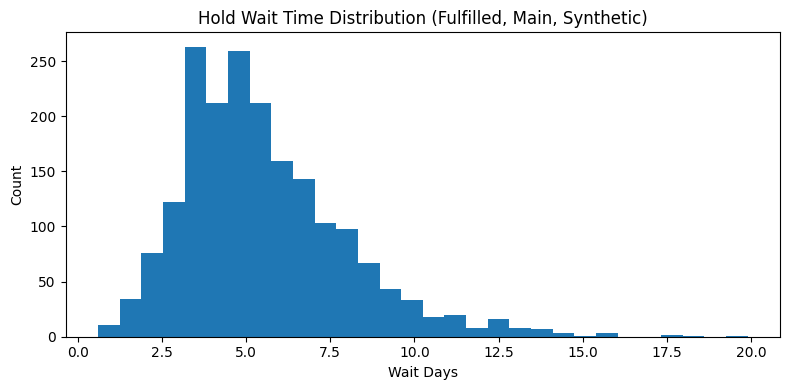

In [17]:
plt.figure(figsize=(8,4))
plt.hist(fulfilled["wait_days"], bins=30)
plt.title("Hold Wait Time Distribution (Fulfilled, Main, Synthetic)")
plt.xlabel("Wait Days")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [18]:
fulfilled = holds[holds["status"].eq("fulfilled")].copy()

hold_kpi = pd.Series({
    "holds_total": len(holds),
    "fulfilled_rate": float((holds["status"]=="fulfilled").mean()),
    "median_wait_days": float(fulfilled["wait_days"].median()),
    "p90_wait_days": float(fulfilled["wait_days"].quantile(0.90)),
    "p95_wait_days": float(fulfilled["wait_days"].quantile(0.95)),
    "max_wait_days": float(fulfilled["wait_days"].max()),
})

hold_kpi


holds_total         2621.000000
fulfilled_rate         0.733689
median_wait_days       5.100000
p90_wait_days          8.600000
p95_wait_days         10.100000
max_wait_days         19.900000
dtype: float64

### Day2 / Viz Clinic #1：Hold 等待时间——“平均值骗人”

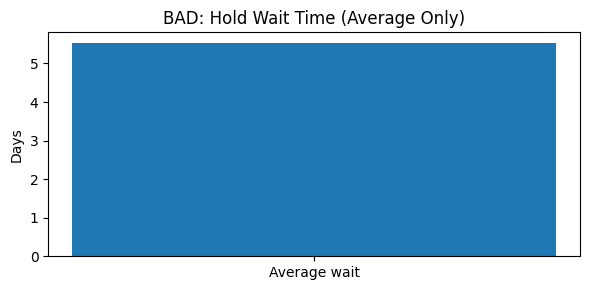

5.530317212688507

In [19]:
avg_wait = fulfilled["wait_days"].mean()

plt.figure(figsize=(6,3))
plt.bar(["Average wait"], [avg_wait])
plt.title("BAD: Hold Wait Time (Average Only)")
plt.ylabel("Days")
plt.tight_layout()
plt.show()

avg_wait


坏图

你跑出来后就能说一句：

“只看平均值，会以为大家都等差不多时间。”

In [20]:
summary = fulfilled["wait_days"].quantile([0.5, 0.9, 0.95]).rename({
    0.5: "median",
    0.9: "p90",
    0.95: "p95"
})
summary["max"] = fulfilled["wait_days"].max()
summary


median     5.1
p90        8.6
p95       10.1
max       19.9
Name: wait_days, dtype: float64

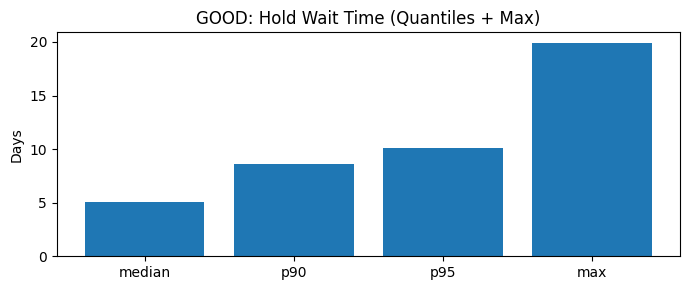

In [21]:
vals = [summary["median"], summary["p90"], summary["p95"], summary["max"]]
labels = ["median", "p90", "p95", "max"]

plt.figure(figsize=(7,3))
plt.bar(labels, vals)
plt.title("GOOD: Hold Wait Time (Quantiles + Max)")
plt.ylabel("Days")
plt.tight_layout()
plt.show()


In [22]:
fulfilled = holds[holds["status"].eq("fulfilled")].copy()
fulfilled["month"] = fulfilled["request_dt"].dt.month

# peak months: Aug–Dec + Jan–May
fulfilled["season"] = np.where(
    fulfilled["month"].isin([8,9,10,11,12,1,2,3,4,5]),
    "semester_peak",
    "summer_offpeak"
)

season_kpi = fulfilled.groupby("season")["wait_days"].agg(
    count="count",
    median="median",
    p90=lambda s: s.quantile(0.90),
    p95=lambda s: s.quantile(0.95),
    max="max"
).round(2)

season_kpi


,count,median,p90,p95,max
season,,,,,
semester_peak,1701,5.3,8.8,10.3,19.9
summer_offpeak,222,3.3,6.6,7.9,14.0


## Viz Clinic #1 — Hold Wait Time: Average hides long-tail pain

**Bad metric:** average wait time = **5.53 days**  
This suggests the experience is “fine”, but it hides the tail.

**Better metrics (service-level):**
- Overall: median **5.1**, p95 **10.1**, max **19.9**
- Semester peak: median **5.3**, p95 **10.3**
- Summer off-peak: median **3.3**, p95 **7.9**

**Interpretation:**
During semester peak, not only does the median increase, but the *tail* gets much worse.
A small subset of patrons may wait 10+ days, which disproportionately drives dissatisfaction.

**Action ideas (what a library might do):**
- Track p90/p95 as SLIs (service-level indicators) in addition to averages.
- Review peak-term staffing or workflows (pickup/processing), and course reserve availability.
- Consider proactive comms for long-wait requests (expectation management).


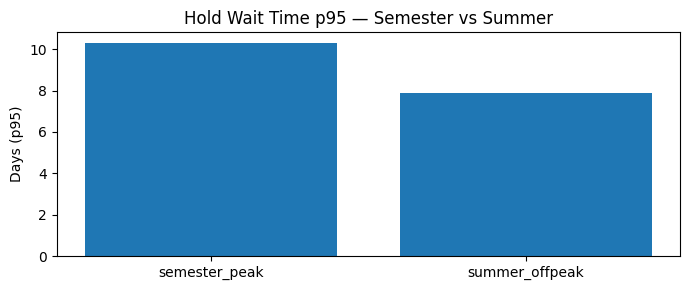

In [23]:
plot_df = season_kpi.reset_index()

plt.figure(figsize=(7,3))
plt.bar(plot_df["season"], plot_df["p95"])
plt.title("Hold Wait Time p95 — Semester vs Summer")
plt.ylabel("Days (p95)")
plt.tight_layout()
plt.show()


Interpretation (for stakeholders):

Median hold wait is ~5.1 days, but the tail is meaningful (p95 ~10.1, max ~19.9).

Reporting only the average hides the long-tail pain experienced by a small but important subset of patrons.

Next steps: monitor p90/p95 as service-level indicators and evaluate peak-term bottlenecks (staffing, reserve policies, item availability).

In [24]:
late_pivot = (txns
    .groupby(["patron_group","collection"])
    .agg(
        transactions=("txn_id","count"),
        late_rate=("is_late","mean")
    )
    .reset_index()
)

# 只保留交易量足够的格子，避免小样本噪声
late_pivot["late_rate"] = late_pivot["late_rate"].round(3)
late_pivot = late_pivot[late_pivot["transactions"] >= 80]

heat = late_pivot.pivot(index="patron_group", columns="collection", values="late_rate")
heat


collection,Book,CourseReserve,DVD,Laptop
patron_group,,,,
Community,0.164,0.164,0.148,NaN
Faculty,0.118,0.138,0.131,0.188
Grad,0.127,0.095,0.158,0.133
Staff,0.112,0.164,0.093,NaN
Undergrad,0.123,0.128,0.114,0.100


In [25]:
late_pivot["risk_score"] = late_pivot["transactions"] * late_pivot["late_rate"]
late_pivot.sort_values("risk_score", ascending=False).head(5)


,patron_group,collection,transactions,late_rate,risk_score
16,Undergrad,Book,8236,0.123,1013.028
8,Grad,Book,3304,0.127,419.608
4,Faculty,Book,1574,0.118,185.732
0,Community,Book,1036,0.164,169.904
12,Staff,Book,1502,0.112,168.224


In [26]:
top5 = late_pivot.sort_values("risk_score", ascending=False).head(5).copy()

recommendations = []
for _, r in top5.iterrows():
    recommendations.append(
        f"- Focus segment: **{r['patron_group']} × {r['collection']}** "
        f"(late_rate={r['late_rate']:.3f}, n={int(r['transactions'])}). "
        "Action: targeted due-date reminders, clearer policy messaging, and quick how-to guides."
    )

print("## Recommended Actions (Late Returns)\n" + "\n".join(recommendations))


## Recommended Actions (Late Returns)
- Focus segment: **Undergrad × Book** (late_rate=0.123, n=8236). Action: targeted due-date reminders, clearer policy messaging, and quick how-to guides.
- Focus segment: **Grad × Book** (late_rate=0.127, n=3304). Action: targeted due-date reminders, clearer policy messaging, and quick how-to guides.
- Focus segment: **Faculty × Book** (late_rate=0.118, n=1574). Action: targeted due-date reminders, clearer policy messaging, and quick how-to guides.
- Focus segment: **Community × Book** (late_rate=0.164, n=1036). Action: targeted due-date reminders, clearer policy messaging, and quick how-to guides.
- Focus segment: **Staff × Book** (late_rate=0.112, n=1502). Action: targeted due-date reminders, clearer policy messaging, and quick how-to guides.


## Viz Clinic #2 — Late Returns: From a single rate to actionable segments

**Bad view:** overall late rate (~12.5%)  
This hides *who* is late and *where* interventions will have the highest impact.

**Better view:** late rate by **patron group × collection**
Key observations:
- **Community × Book** shows the highest late rate (~0.164), suggesting a higher-risk segment (policy clarity + reminders may help).
- **Faculty × Laptop** shows a notably high late rate (~0.188). Even if volume is smaller, laptops are high-value items → consider stricter reminders or shorter grace periods.
- Book dominates volume across groups → it drives overall impact.

**Prioritized actions (impact-weighted)**
Top segments by (transactions × late_rate):
- Undergrad × Book (late_rate≈0.123, n≈8236)
- Grad × Book (late_rate≈0.127, n≈3304)
- Faculty × Book (late_rate≈0.118, n≈1574)
- Community × Book (late_rate≈0.164, n≈1036)
- Staff × Book (late_rate≈0.112, n≈1502)

**Action ideas**
- Targeted due-date reminders and renewal nudges for high-volume segments (Undergrad/Grad × Book).
- Clearer policy messaging for Community users (onboarding handout + FAQ).
- Asset-protection workflow for Laptop loans (earlier reminders, verification, or adjusted loan policy).


In [27]:
top = late_pivot.sort_values("risk_score", ascending=False).head(8).copy()
top["late_rate"] = top["late_rate"].round(3)
top[["patron_group","collection","transactions","late_rate","risk_score"]]


,patron_group,collection,transactions,late_rate,risk_score
16,Undergrad,Book,8236,0.123,1013.028
8,Grad,Book,3304,0.127,419.608
4,Faculty,Book,1574,0.118,185.732
0,Community,Book,1036,0.164,169.904
12,Staff,Book,1502,0.112,168.224
18,Undergrad,DVD,1029,0.114,117.306
17,Undergrad,CourseReserve,849,0.128,108.672
10,Grad,DVD,367,0.158,57.986




“我不是只盯着最高逾期率，我用影响面做优先级。”

“标注 Top 3 风险点”的表格输出。

In [28]:
import os
os.makedirs("data", exist_ok=True)

items.to_csv("data/items.csv", index=False)
patrons.to_csv("data/patrons.csv", index=False)
txns.to_csv("data/txns.csv", index=False)
holds.to_csv("data/holds.csv", index=False)
print("saved to data/")


saved to data/
